In [19]:
import findspark
findspark.init()

import os
os.environ['PYSPARK_DRIVER_PYTHON'] = r'c:\Users\Ming\anaconda3\envs\ds\python.exe'

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode_outer, udf, max
from pyspark.sql.types import StringType, IntegerType, FloatType

import json
from pathlib import Path
import tqdm

In [2]:
print(os.environ['PYSPARK_DRIVER_PYTHON'])
print(os.environ['PYSPARK_PYTHON'])

c:\Users\Ming\anaconda3\envs\ds\python.exe
c:\Users\Ming\anaconda3\envs\ds\python.exe


In [66]:
class SparkExtractor:
    def __init__(self, spark):
        self.spark = spark
        self.tree = None
        self.years = [2018, 2019, 2020, 2021, 2022, 2023]

    def reset(self):
        self.tree = None

    def getID(self, sgr_id_with_prefix):
        return sgr_id_with_prefix.split(':')[1]

    def extractSgrId(self, data):
        sgr_id_with_prefix = data['abstracts-retrieval-response']['coredata']['dc:identifier']
        sgr_id = self.getID(sgr_id_with_prefix)
        return sgr_id
    
    def extractReferences(self, data):
        try:
            reference_text = data['abstracts-retrieval-response']['item']['bibrecord']['tail']['bibliography']['reference']
        except:
            return []
        
        references = []
        for reference in reference_text:
            if type(reference) == str:
                 reference = reference_text
            for ids in reference['ref-info']['refd-itemidlist']['itemid']:
                if type(ids) == str:
                    ids = reference['ref-info']['refd-itemidlist']['itemid']
                if ids['@idtype'] == 'SGR':
                    references.append(ids['$'])
                    continue
        return references


    def extract(self, path, include_references=True):
        with open(path, 'r') as file:
            data = json.load(file)

        sgr_id = self.extractSgrId(data)
        if not include_references:
            return sgr_id
        
        references = self.extractReferences(data)
        
        return sgr_id, references
    
    def findPathFromId(self, target_id):
        for year in self.years:
            print(f'Checking year {year}')
            directory = Path(f'./Project/{year}')
            for file in directory.iterdir():
                if not file.is_file():
                    continue
                sgr_id = self.extract(file, include_references=False)
                if sgr_id == target_id:
                    return file
        return None
    
    def findPathFromIdList(self, target_id_list):
        paths = {}
        for year in tqdm.tqdm(self.years):
            directory = Path(f'./Project/{year}')
            for file in directory.iterdir():
                if not file.is_file():
                    continue
                sgr_id = self.extract(file, include_references=False)
                if sgr_id in target_id_list.keys():
                    paths[file] = [sgr_id, target_id_list[sgr_id]]
                    if len(paths) == len(target_id_list):
                        return paths
        return paths

    def expandTree(self, target_id_list, depth):
        all_ref_df = self.spark.createDataFrame([(r, target_id_list[r], depth, False) for r in target_id_list.keys()], 
                                                ['sgr_id', 'parent_id', 'depth', 'is_in_dataset'])
        self.tree = self.tree.union(all_ref_df)
        self.tree = self.tree.distinct()
        self.tree = self.tree.groupBy('sgr_id', 'parent_id', 'depth').agg(max('is_in_dataset').alias('is_in_dataset'))
        

    def extractTree(self, path, depth, expand = False):
        sgr_id, references = self.extract(path)
        target_id_list = {}
        for reference in references:
            target_id_list[reference] = sgr_id
        self.tree = self.spark.createDataFrame([(sgr_id, '', 0, True)], ['sgr_id', 'parent_id', 'depth', 'is_in_dataset'])

        for d in range(depth):
            print(f'Processing depth {d}')
            paths = self.findPathFromIdList(target_id_list)
            if len(paths) == 0:
                break
            new_nodes = []
            for p, ids in paths.items():
                sgr_id, parent_id = ids
                if parent_id is None or sgr_id is None:
                    continue
                new_nodes.append((sgr_id, parent_id, d+1, True))
            #print(new_nodes)
            
            new_nodes_df = self.spark.createDataFrame(new_nodes, ['sgr_id', 'parent_id', 'depth', 'is_in_dataset'])
            self.tree = self.tree.union(new_nodes_df)
            self.tree = self.tree.distinct()

            if expand:
                self.expandTree(target_id_list, d+1)

            target_id_list = {}
            for new_parent_path in paths.keys():
                sgr_id, references = self.extract(new_parent_path)
                for reference in references:
                    target_id_list[reference] = sgr_id

        # sort by depth
        self.tree = self.tree.orderBy('depth')
        return self.tree

In [67]:
spark = SparkSession.builder.master('local').appName('Spark SQL').getOrCreate()
spe = SparkExtractor(spark)

In [68]:
#85060936020
path = './Project/2023/202300003'
tmp = spe.extract(path)
print(tmp)

('85167831666', ['84885467693', '84870560686', '85065989510', '85113293498', '0036837179', '0033038506', '85092488250', '85069676260', '85106888680', '85088035820', '84946433964', '85077495976', '85107002550', '33144477569', '0029668959', '84969245655', '84991687666', '85073054256', '85135500731', '85109709126', '0026499429', '34249024956', '85046638748', '85071901027', '85069892206', '85118439680', '85099807135', '0032063792', '84860227595', '85081139572', '85067013223', '84948121530', '85040326141', '85049915524', '85126675600', '85121273609', '85081278923', '85131427167', '84948160035', '85072893038', '0018178434', '80052762366', '84921321402', '31744436891', '37349051021', '62649118197', '84934999721', '0025441987', '70450265235', '84959326723', '85052847624', '84962162054', '85056883964', '84902593108', '84920719019', '85003968478', '85026308072', '84893830168', '0003710288', '85109633092', '0031776701', '85101096171', '63149096086', '85087177046', '85078007750', '85139015826', '8

In [69]:
spe.extractTree(path, 2, expand = True).show()

Processing depth 0


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:38<00:00,  6.40s/it]


Processing depth 1


100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


+-----------+-----------+-----+-------------+
|     sgr_id|  parent_id|depth|is_in_dataset|
+-----------+-----------+-----+-------------+
|85167831666|           |    0|         true|
|84959326723|85167831666|    1|        false|
|85078007750|85167831666|    1|        false|
|62649118197|85167831666|    1|        false|
|70450265235|85167831666|    1|        false|
|85072893038|85167831666|    1|        false|
|85065989510|85167831666|    1|        false|
|85003968478|85167831666|    1|        false|
|85118439680|85167831666|    1|        false|
|84948160035|85167831666|    1|        false|
|84902593108|85167831666|    1|        false|
|85053084000|85167831666|    1|        false|
|85077495976|85167831666|    1|        false|
|85126675600|85167831666|    1|        false|
| 0030141244|85167831666|    1|        false|
|85132352122|85167831666|    1|        false|
|84870560686|85167831666|    1|        false|
|85088035820|85167831666|    1|        false|
|84893830168|85167831666|    1|   

In [65]:
spe.tree.count()

171

In [73]:
spe.tree.show(100)

+-----------+-----------+-----+-------------+
|     sgr_id|  parent_id|depth|is_in_dataset|
+-----------+-----------+-----+-------------+
|85167831666|           |    0|         true|
|84959326723|85167831666|    1|        false|
|85078007750|85167831666|    1|        false|
|62649118197|85167831666|    1|        false|
|70450265235|85167831666|    1|        false|
|85072893038|85167831666|    1|        false|
|85065989510|85167831666|    1|        false|
|85003968478|85167831666|    1|        false|
|85118439680|85167831666|    1|        false|
|84948160035|85167831666|    1|        false|
|84902593108|85167831666|    1|        false|
|85053084000|85167831666|    1|        false|
|85077495976|85167831666|    1|        false|
|85126675600|85167831666|    1|        false|
| 0030141244|85167831666|    1|        false|
|85132352122|85167831666|    1|        false|
|84870560686|85167831666|    1|        false|
|85088035820|85167831666|    1|        false|
|84893830168|85167831666|    1|   

In [137]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

class GraphGephi:
    def __init__(self, tree):
        self.tree = tree
        self.G = nx.DiGraph()
        self.colours = {
            0: (200, 0, 0),
            1: (7, 87, 91),
            2: (97, 164, 173),
            3: (192, 222, 229)
        }

    def init_graph(self):
        self.tree = self.tree.orderBy('depth', ascending = False)

        # add nodes
        for row in self.tree.collect():
            self.G.add_node(row.sgr_id, depth = row.depth)

        # add edges
        for row in self.tree.collect():
            if row.parent_id != '':
                self.G.add_edge(row.parent_id, row.sgr_id)

    def init_pos(self, random_pos = True):
        if random_pos:
            self.pos = nx.random_layout(self.G)
        else:
            self.pos = {}
            initial_radius = 1
            depth_nodes = {}
            for node in self.G.nodes():
                depth = self.G.nodes[node]['depth']
                if depth not in depth_nodes:
                    depth_nodes[depth] = []
                depth_nodes[depth].append(node)
            for depth, node in depth_nodes.items():
                angle = 2 * np.pi / len(node)
                for i, n in enumerate(node):
                    self.pos[n] = (initial_radius * depth * np.cos(i * angle), initial_radius * depth * np.sin(i * angle))

    def draw(self):
        colours_norm = {k: tuple([x / 255 for x in v]) for k, v in self.colours.items()}
        used_colours = [colours_norm[self.G.nodes[node]['depth'] % len(colours_norm)] for node in self.G.nodes()]
        nx.draw(self.G, self.pos, node_color=used_colours)
        plt.show()

    def export_gexf(self, path):
        for n in self.G.nodes():
            r, g, b = self.colours[self.G.nodes[n]['depth']]
            viz_colour = {'r': r, 'g': g, 'b': b, 'a': int(0.6*255)}
            nx.set_node_attributes(self.G, {n[0]: {'viz': {'color': viz_colour}}})
        nx.write_gexf(self.G, path)


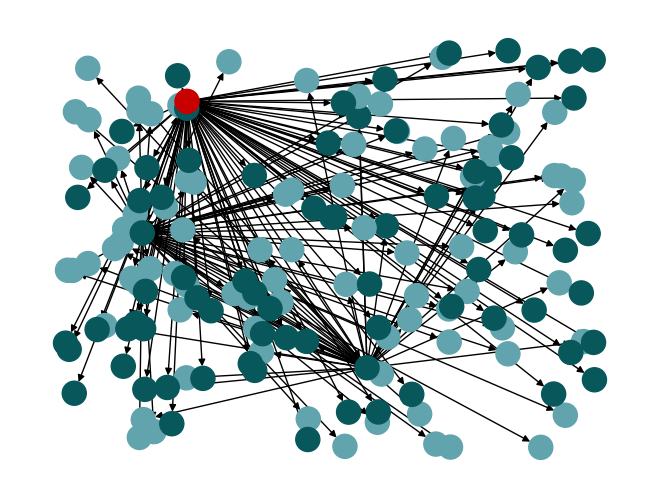

In [138]:
graph = GraphGephi(spe.tree)
graph.init_graph()
graph.init_pos()
graph.draw()
graph.export_gexf('./graph.gexf')